# Imports

In [9]:
import torch as t 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from datasets import load_dataset
from datasets import Dataset

from tqdm import tqdm

from sloth_parse import parse_bytearray_string_to_sloth_mlp, parse_bytearray_string_to_sloth_cnn

# Data Preprocessing Functions
Can ignore all of this if just training

In [2]:
def process_datapoint(datapoint: dict[str, any]) -> dict[str, any]:
    """
    Map function for the dataset to convert the data into a format that can be used by the model.
    (viz. convert the state from a bytearray string to a tensor)
    Args:
        datapoint: the datapoint to be processed

    Returns:

    """
    game_state_tensor = parse_bytearray_string_to_sloth_cnn(datapoint['state'])
    
    wins = int(datapoint['num_wins'])
    losses = int(datapoint['num_losses'])
    draws = int(datapoint['num_draws'])
    num_games = wins + losses + draws
    score = t.tensor(0.0 if num_games == 0 else (wins - losses) / num_games)
    # this score function attempts to normalize the score to be between -1 and 1, like an evaluation function should
    
    return {
        'tensor_state': game_state_tensor,
        'score': score
    }
    
    

In [3]:
def get_dataset(split: str) -> Dataset:
    if split not in ['train', 'validation', 'test']:
        raise ValueError(f"Invalid split: {split}")
    
    dataset = load_dataset('markstanl/u3t', split=split)
    return dataset

In [4]:
train = get_dataset('train')
test = get_dataset('test')
val = get_dataset('validation')

In [5]:
def get_tensor_dataset(dataset: Dataset) -> Dataset:
    dataset = dataset.remove_columns(['num_visits', 'actions', 'depth'])
    
    dataset = dataset.map(process_datapoint)
    dataset.set_format(type='torch', columns=['tensor_state'])
        
    dataset = dataset.remove_columns(['state', 'num_wins', 'num_losses', 'num_draws'])
    
    return dataset
    
def save_tensor_dataset(dataset: Dataset, split: str):
    dataset.to_parquet(f'sloth_{split}.parquet')
    
def make_tensor_dataset(dataset: Dataset, split: str):
    tensor_dataset = get_tensor_dataset(dataset)
    save_tensor_dataset(tensor_dataset, split)

In [7]:
make_tensor_dataset(train, 'train')
make_tensor_dataset(test, 'test')
make_tensor_dataset(val, 'validation')

Map:   0%|          | 0/5601458 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5602 [00:00<?, ?ba/s]

Map:   0%|          | 0/1600367 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1601 [00:00<?, ?ba/s]

Map:   0%|          | 0/800165 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/801 [00:00<?, ?ba/s]

Though, run this block to get the data loader from your local dataset

In [10]:
def get_local_data_loader(split: str, cnn: bool=False) -> t.utils.data.DataLoader:
    """
    Get a DataLoader for the given split of the data. Converts the data to tensors.
    Args:
        split: the split of the data to get the DataLoader for
        cnn: boolean to use the cnn split

    Returns:
        DataLoader: the DataLoader for the given split
    """
    if cnn:
        dataset = Dataset.from_parquet(f'sloth_data/sloth_{split}_cnn.parquet')
    else:
        dataset = Dataset.from_parquet(f'sloth_data/sloth_{split}.parquet')
    dataset.set_format(type='torch', columns=['tensor_state', 'score'])
    
    loader = t.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    return loader

def get_loader_from_dataset(dataset: Dataset) -> t.utils.data.DataLoader:
    dataset.set_format(type='torch', columns=['tensor_state', 'score'])
    
    loader = t.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    return loader

def get_local_dataset(split: str) -> Dataset:
    return Dataset.from_parquet(f'sloth_data/sloth_{split}.parquet')

# Sloth ML Construction

In [17]:
class Sloth(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(324, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

In [11]:
def evaluate(model: nn.Module, 
             loader: t.utils.data.DataLoader, 
             criterion: t.nn.modules.loss,
             num_batches: int = 100):
    
    model.eval()
    with t.no_grad():
        total_loss = 0
        total_error = 0
        num_data_points = 0
        
        for i, batch in enumerate(loader):
            if i >= num_batches:
                break
            state, score = batch['tensor_state'], batch['score']
            output = model(state)
            loss = criterion(output, score.unsqueeze(1))
            
            num_data_points += len(score)
            total_loss += loss.item()
            total_error += t.sum(t.abs(output - score.unsqueeze(1))).item()
        loss = total_loss / num_data_points
        error = total_error / num_data_points
        
        return loss, error
    

In [41]:
def train(model: nn.Module, 
          loader: t.utils.data.DataLoader, 
          optimizer: t.optim, 
          criterion: t.nn.modules.loss, 
          num_epochs: int,
          test_loader: t.utils.data.DataLoader,
          epoch_start: int = 0,
          path_name: str = None) -> list[tuple[float, float]]:
    """
    Train the model on the given data
    Args:
        model: the model to train
        loader: the DataLoader for the data
        optimizer: the optimizer to use
        criterion: the loss function to use
    """
    model.train()
    history = []
    save_path = path_name if path_name else "sloth_models/model_cnn_epoch_{epoch}.pth"
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_error = 0
        num_data_points = 0
        
        for i, batch in tqdm(enumerate(loader)):
            optimizer.zero_grad()
            state, score = batch['tensor_state'], batch['score']
            output = model(state)
            loss = criterion(output, score.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            num_data_points += len(score)
            total_loss += loss.item()
            total_error += t.sum(t.abs(output - score.unsqueeze(1))).item()
            
            # if (i*32) % 500_000 == 0:
            #     print(f"       Iteration {i} Loss: {total_loss / num_data_points} Average Error {total_error / num_data_points}")
                
        loss = total_loss / num_data_points
        error = total_error / num_data_points
                        
        if test_loader is None:
            print(f"Epoch {epoch + epoch_start} Loss: {loss} Average Error {error}")
            history.append((loss, error))
        else:
            test_loss, test_error = evaluate(model, test_loader, criterion, num_batches=100)
            print(f"Epoch {epoch + epoch_start} Loss: {loss} Average Error {error} Test Loss: {test_loss} Test Error: {test_error}")
            history.append((loss, error, test_loss, test_error))
        
        try:
            t.save({
                'epoch': epoch+epoch_start+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,  
            }, save_path.format(epoch=epoch+epoch_start+1))
        except Exception:
                        t.save({
                'epoch': epoch+epoch_start+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,  
            }, "sloth_models/backup_model_{epoch}.pth".format(epoch=epoch+10))
        
    return history

In [13]:
train_loader = get_local_data_loader('train')
test_loader = get_local_data_loader('test')

In [14]:
model_dict = t.load('sloth_models/model_epoch_5.pth')

In [18]:
model = Sloth()
model.load_state_dict(model_dict['model_state_dict'])

<All keys matched successfully>

In [19]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
history = train(model, train_loader, optimizer, criterion, num_epochs=20, test_loader=test_loader)

In [49]:
class AlphaU3T_Stride1(nn.Module):
    def __init__(self):
        super(AlphaU3T_Stride1, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        
        self.fc1 = nn.Linear(256 * 9 * 9, 512)  # Assuming input is 9x9
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        
        x = t.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = self.relu6(x)
        x = self.fc3(x)
        
        return x

class AlphaU3T_Deeper(nn.Module):
    def __init__(self):
        super(AlphaU3T_Deeper, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 128, kernel_size=3, stride=3, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=3, padding=0)
        self.relu2 = nn.ReLU()
        
        self.fc1 = nn.Linear(256, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu6 = nn.ReLU()
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = t.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.fc4(x)
        
        return x


In [44]:
cnn_train_loader = get_local_data_loader('train', cnn=True)
cnn_test_loader = get_local_data_loader('test', cnn=True)

Loading dataset shards:   0%|          | 0/17 [00:01<?, ?it/s]

In [50]:
CNN_deeper = AlphaU3T_Deeper()
CNN_low_stride = AlphaU3T_Stride1()

In [40]:
deep_optimizer = optim.Adam(CNN_deeper.parameters(), lr=0.01)
deep_criterion = nn.MSELoss()

small_optimizer = optim.Adam(CNN_low_stride.parameters(), lr=0.01)
small_criterion = nn.MSELoss()

In [51]:
history_deep = train(CNN_deeper, cnn_train_loader, deep_optimizer, deep_criterion, num_epochs=3, test_loader=cnn_test_loader, path_name= "sloth_models/deep_{epoch}.pth")
history_small = train(CNN_low_stride, cnn_train_loader, small_optimizer, small_criterion, num_epochs=3, test_loader=cnn_test_loader, path_name= "sloth_models/small_{epoch}.pth")

175046it [3:16:36, 14.84it/s]


Epoch 0 Loss: 0.003667584357230146 Average Error 0.1970615961488724 Test Loss: 0.003665852502454072 Test Error: 0.19781354919075966


175046it [3:15:32, 14.92it/s]


Epoch 1 Loss: 0.0036675846930803203 Average Error 0.1970615961358692 Test Loss: 0.0035742034472059456 Test Error: 0.19446256175637244


175046it [3:14:28, 15.00it/s]


Epoch 2 Loss: 0.0036675917222465547 Average Error 0.19706159615083033 Test Loss: 0.00369506279588677 Test Error: 0.19628638960421085


175046it [9:00:49,  5.39it/s]


Epoch 0 Loss: 0.003652560282939212 Average Error 0.19527091542639669 Test Loss: 0.003527253976208158 Test Error: 0.19072815373539925


175046it [9:13:18,  5.27it/s]


Epoch 1 Loss: 0.00365256787968044 Average Error 0.19527091539862387 Test Loss: 0.0037444021744886414 Test Error: 0.1963022192567587


7132it [21:58,  5.41it/s]


KeyboardInterrupt: 

In [53]:
with open('sloth_models/cnn_history', 'w') as f:
    f.write("history_deep:\n")
    for item in history_deep:
        f.write(str(item) + "\n")

    f.write("\n\nhistory_small:\n")
    f.write("Epoch 0 Loss: 0.003652560282939212 Average Error 0.19527091542639669 Test Loss: 0.003527253976208158 Test Error: 0.19072815373539925")
    f.write("Epoch 1 Loss: 0.00365256787968044 Average Error 0.19527091539862387 Test Loss: 0.0037444021744886414 Test Error: 0.1963022192567587")
    

# BetaGo ML Construction

In [31]:
class AlphaU3T(nn.Module):
    """
    The AlphaU3T model takes inspiration from the AlphaGo from Google model for the game go. Specifically, it takes inspiration from the
    value model associated with the model. Though, it is learned on a much smaller model
    """
    def __init__(self):
        super(AlphaU3T, self).__init__()
        
        # convolutional layer
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=3, padding=0)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=3, padding=0)
        self.relu2 = nn.ReLU()
        
        # dense layers
        self.fc1 = nn.Linear(64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        """
        Forward Method
        """
        x = x.float()
        
        # convolutional layer
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        
        # flatten
        x = t.flatten(x, start_dim=1) 
        
        # dense layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        
        return x

In [32]:
cnn_model = AlphaU3T()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [18]:
train_loader = get_local_data_loader('train', True)
test_loader = get_local_data_loader('test', True)

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [25]:
example = next(iter(train_loader))

In [30]:
tensor_example = example['tensor_state'][0]
print(tensor_example.shape)

torch.Size([4, 9, 9])


In [35]:
history_cnn = train(cnn_model, train_loader, optimizer, criterion, num_epochs=5, test_loader=test_loader, epoch_start=6)

175046it [3:08:42, 15.46it/s]


Epoch 6 Loss: 0.003656460857605309 Average Error 0.19787686282437814 Test Loss: 0.003802773815114051 Test Error: 0.20328570924699307


175046it [3:09:28, 15.40it/s]


Epoch 7 Loss: 0.0036565309992870544 Average Error 0.19787002246452515 Test Loss: 0.003543241294682957 Test Error: 0.19356504410505296


175046it [3:04:30, 15.81it/s]


Epoch 8 Loss: 0.003656558411508088 Average Error 0.19786868054750925 Test Loss: 0.0036529532074928285 Test Error: 0.19978500708937644


175046it [3:04:12, 15.84it/s]


Epoch 9 Loss: 0.0036565793443913692 Average Error 0.19788149627265517 Test Loss: 0.003708244788867887 Test Error: 0.19693719387054442


175046it [2:57:32, 16.43it/s]


Epoch 10 Loss: 0.0036564562905072725 Average Error 0.19787700443464767 Test Loss: 0.0036842143334797585 Test Error: 0.19886592507362366


In [36]:
print(history_cnn)

[(0.003656460857605309, 0.19787686282437814, 0.003802773815114051, 0.20328570924699307), (0.0036565309992870544, 0.19787002246452515, 0.003543241294682957, 0.19356504410505296), (0.003656558411508088, 0.19786868054750925, 0.0036529532074928285, 0.19978500708937644), (0.0036565793443913692, 0.19788149627265517, 0.003708244788867887, 0.19693719387054442), (0.0036564562905072725, 0.19787700443464767, 0.0036842143334797585, 0.19886592507362366)]


# Understanding Data Conversion
I am having trouble with the tensors in the dataset. I realized the issue was with loading datasets as tensors from the parquet file, the solution is to set the format of the dataset to torch when loading.

In [131]:
train_test = train[:10]
train_test_dataset = Dataset.from_dict(train_test)

tensor_dataset = get_tensor_dataset(train_test_dataset)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Column 'state': string
Column 'num_wins': int64
Column 'num_draws': int64
Column 'num_losses': int64
Column 'tensor_state': list
Column 'score': float32


In [136]:
make_tensor_dataset(train_test_dataset, 'train_test')
loader = get_local_data_loader('train_test')

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [137]:
batch = next(iter(loader))

In [138]:
example = batch['tensor_state'][0]
print(type(example))

<class 'torch.Tensor'>


In [140]:
print(example.shape)

torch.Size([4, 81])


In [149]:
tensors = batch['tensor_state']
print(model(tensors))

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0

# Evaluation

In [ ]:
test_loader = get_local_data_loader('test')

In [ ]:
evaluate(model, test_loader)

# Visualization

In [3]:
test_set = get_local_dataset('test')


Dataset({
    features: ['tensor_state', 'score'],
    num_rows: 1600367
})


In [4]:
scores = test_set['score']

In [9]:
import matplotlib.pyplot as plt
import numpy as np

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



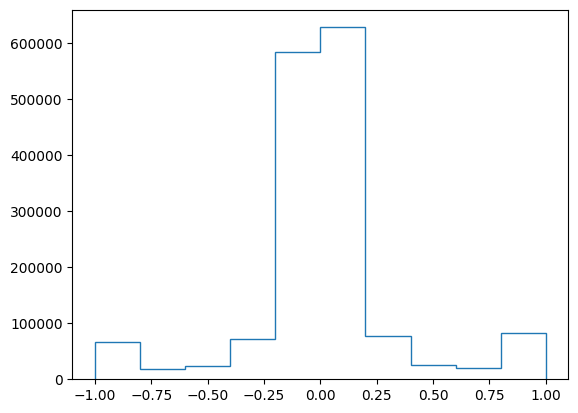

In [12]:
print(scores)
counts, bins = np.histogram(scores)
plt.stairs(counts, bins)
plt.show()
